# fully-connected neural network

In [1]:
#! conda activate tf-gpu

In [2]:
import json
import os
from copy import deepcopy
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

2025-04-02 21:08:00.807666: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-02 21:08:00.814450: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743642480.822990  240028 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743642480.825862  240028 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-02 21:08:00.834709: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [3]:
%load_ext autoreload
%autoreload 2

## 1. dataset

In [4]:
infile = '/home/yuan/results/epitope/combined_features.txt'
df = pd.read_csv(infile, sep='\t', header=0, index_col=None)
# shuffle rows
df = df.sample(frac=1)
df['label'] = df['label'].map({'epitope':1, 'other': 0, 'random':0})
print(df.shape)

(3182867, 457)


In [5]:
X = np.array(df.iloc[:,2:], dtype=np.float16)
y = np.array(df.iloc[:,1], dtype=np.float16)
print(X.shape, X.dtype, y.shape, y.dtype)

from collections import Counter
Counter(y)

(3182867, 455) float16 (3182867,) float16


Counter({np.float16(1.0): 1798795, np.float16(0.0): 1384072})

In [6]:
# normalization X
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
norm_X = scaler.fit_transform(X)

In [7]:
#split data into train and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(norm_X, y, train_size=0.8, shuffle=True, random_state=2)
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, train_size=0.7, shuffle=True, random_state=2)
print(X_train.shape, y_train.shape)
print(X_validate.shape, y_validate.shape)
print(X_test.shape, y_test.shape)

(1782405, 455) (1782405,)
(763888, 455) (763888,)
(636574, 455) (636574,)


## 2. train model

In [8]:
from tensorflow.keras.layers import Input, Dense, Dropout

# input features
num_features = int(X.shape[-1])
# outccome is binary
model = tf.keras.Sequential([
    Input(shape=(num_features,)),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(96, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid'),
])
model.summary()

I0000 00:00:1743642552.180360  240028 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9185 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │       233,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 96)             │        49,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            97 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 282,817 (1.08 MB)

 Trainable params: 282,817 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# loss_fn = tf.keras.losses.sparse_categorical_crossentropy
optim = tf.keras.optimizers.Adam(learning_rate=0.001)

def weighted_binary_crossentropy(pos_weight=1.0):
    def loss(y_true, y_pred):
        # Standard BCE
        bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        # Apply weighting
        weight_vector = y_true * pos_weight + (1 - y_true) * 1.0
        weighted_bce = weight_vector * bce
        
        return tf.reduce_mean(weighted_bce)
    return loss
    
model.compile(
    # loss=tf.keras.losses.BinaryCrossentropy,
    loss=weighted_binary_crossentropy(pos_weight=.5),
    optimizer=optim,
    metrics=['accuracy', 'precision', 'recall', 'auc', 'mse']
)

epochs = 10
history= model.fit(
    X_train,
    y_train,
    validation_data=(X_validate, y_validate),
    epochs=epochs,
    verbose=True
)

res = pd.DataFrame(history.history)
print(res.head(3))
print(res.tail(3))

Epoch 1/10


I0000 00:00:1743642556.269037  240183 service.cc:148] XLA service 0x7a607c004b70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743642556.269055  240183 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-04-02 21:09:16.298644: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1743642556.378784  240183 cuda_dnn.cc:529] Loaded cuDNN version 90800


   70/55701 ━━━━━━━━━━━━━━━━━━━━ 1:21 1ms/step - accuracy: 0.5899 - auc: 0.5871 - loss: 0.5077 - mse: 0.2546 - precision: 0.6401 - recall: 0.7297

I0000 00:00:1743642556.965551  240183 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


55701/55701 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7224 - auc: 0.7729 - loss: 0.4051 - mse: 0.1892 - precision: 0.7184 - recall: 0.8373

E0000 00:00:1743642644.047553  240192 buffer_comparator.cc:157] Difference at 16: 0, expected 260.803
E0000 00:00:1743642644.047578  240192 buffer_comparator.cc:157] Difference at 17: 0, expected 274.951
E0000 00:00:1743642644.047581  240192 buffer_comparator.cc:157] Difference at 18: 0, expected 253.659
E0000 00:00:1743642644.047584  240192 buffer_comparator.cc:157] Difference at 19: 0, expected 257.607
E0000 00:00:1743642644.047586  240192 buffer_comparator.cc:157] Difference at 20: 0, expected 250.262
E0000 00:00:1743642644.047587  240192 buffer_comparator.cc:157] Difference at 21: 1, expected 258.782
E0000 00:00:1743642644.047589  240192 buffer_comparator.cc:157] Difference at 22: 0, expected 253.591
E0000 00:00:1743642644.047591  240192 buffer_comparator.cc:157] Difference at 23: 0, expected 258.759
E0000 00:00:1743642644.047592  240192 buffer_comparator.cc:157] Difference at 24: 1, expected 259.406
E0000 00:00:1743642644.047594  240192 buffer_comparator.cc:157] Difference at 25: 

55701/55701 ━━━━━━━━━━━━━━━━━━━━ 117s 2ms/step - accuracy: 0.7224 - auc: 0.7729 - loss: 0.4051 - mse: 0.1892 - precision: 0.7184 - recall: 0.8373 - val_accuracy: 0.7432 - val_auc: 0.8014 - val_loss: 0.3851 - val_mse: 0.1781 - val_precision: 0.7272 - val_recall: 0.8726
Epoch 2/10
55701/55701 ━━━━━━━━━━━━━━━━━━━━ 105s 2ms/step - accuracy: 0.7479 - auc: 0.8017 - loss: 0.3834 - mse: 0.1762 - precision: 0.7337 - recall: 0.8699 - val_accuracy: 0.7486 - val_auc: 0.8076 - val_loss: 0.3795 - val_mse: 0.1738 - val_precision: 0.7380 - val_recall: 0.8602
Epoch 3/10
55701/55701 ━━━━━━━━━━━━━━━━━━━━ 116s 2ms/step - accuracy: 0.7519 - auc: 0.8083 - loss: 0.3783 - mse: 0.1734 - precision: 0.7362 - recall: 0.8742 - val_accuracy: 0.7461 - val_auc: 0.8068 - val_loss: 0.3797 - val_mse: 0.1749 - val_precision: 0.7271 - val_recall: 0.8810
Epoch 4/10
55701/55701 ━━━━━━━━━━━━━━━━━━━━ 112s 2ms/step - accuracy: 0.7554 - auc: 0.8132 - loss: 0.3745 - mse: 0.1713 - precision: 0.7390 - recall: 0.8775 - val_accuracy

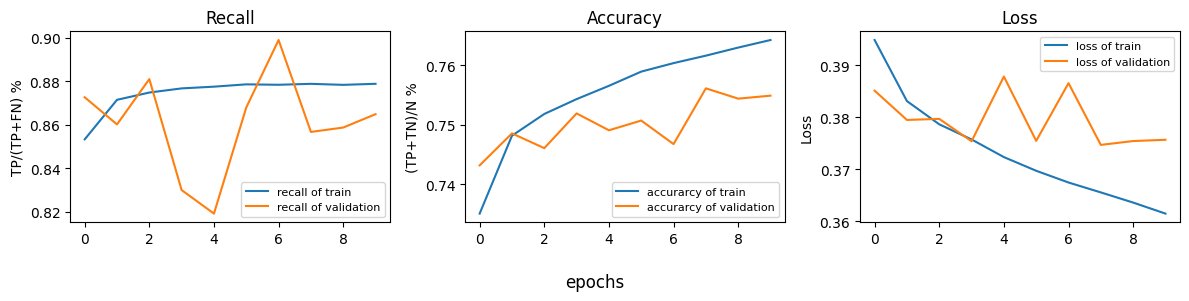

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(12,3), layout='tight')
x = range(epochs)
fig.supxlabel('epochs')

i=0
axes[i].plot(x, history.history['recall'], label='recall of train')
axes[i].plot(x, history.history['val_recall'], label='recall of validation')
axes[i].set_ylabel('TP/(TP+FN) %')
axes[i].set_title('Recall')
axes[i].legend(loc='lower right', fontsize=8)

i=1
axes[i].plot(x, history.history['accuracy'], label='accurarcy of train')
axes[i].plot(x, history.history['val_accuracy'], label='accurarcy of validation')
axes[i].set_ylabel('(TP+TN)/N %')
axes[i].set_title('Accuracy')
axes[i].legend(loc='lower right', fontsize=8)

i=2
axes[i].plot(x, history.history['loss'], label='loss of train')
axes[i].plot(x, history.history['val_loss'], label='loss of validation')
axes[i].set_ylabel('Loss')
axes[i].set_title('Loss')
axes[i].legend(loc='upper right', fontsize=8)

In [11]:
eval_res = model.evaluate(X_test, y_test, return_dict=True)
print(eval_res)

19890/19893 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7553 - auc: 0.8177 - loss: 0.3761 - mse: 0.1705 - precision: 0.7430 - recall: 0.8650

E0000 00:00:1743643648.011525  240183 buffer_comparator.cc:157] Difference at 16: -0.719727, expected 261.95
E0000 00:00:1743643648.011549  240183 buffer_comparator.cc:157] Difference at 17: 0.740723, expected 267.991
E0000 00:00:1743643648.011552  240183 buffer_comparator.cc:157] Difference at 18: -0.75, expected 268.791
E0000 00:00:1743643648.011554  240183 buffer_comparator.cc:157] Difference at 19: -0.449707, expected 251.978
E0000 00:00:1743643648.011557  240183 buffer_comparator.cc:157] Difference at 20: -0.640137, expected 256.71
E0000 00:00:1743643648.011559  240183 buffer_comparator.cc:157] Difference at 21: -0.0301971, expected 256.73
E0000 00:00:1743643648.011560  240183 buffer_comparator.cc:157] Difference at 22: -0.863281, expected 259.493
E0000 00:00:1743643648.011562  240183 buffer_comparator.cc:157] Difference at 23: 0.00452042, expected 258.042
E0000 00:00:1743643648.011564  240183 buffer_comparator.cc:157] Difference at 24: -0.349121, expected 262.804
E0000 00:00:1743

19893/19893 ━━━━━━━━━━━━━━━━━━━━ 24s 1ms/step - accuracy: 0.7553 - auc: 0.8177 - loss: 0.3761 - mse: 0.1705 - precision: 0.7430 - recall: 0.8650
{'accuracy': 0.7549868226051331, 'auc': 0.8175697922706604, 'loss': 0.37609076499938965, 'mse': 0.17047135531902313, 'precision': 0.7433168888092041, 'recall': 0.8644510507583618}


In [12]:
pred_test = model.predict(X_test)
pred_test[:3]

19893/19893 ━━━━━━━━━━━━━━━━━━━━ 10s 485us/step


array([[0.98407584],
       [0.08495802],
       [0.40712687]], dtype=float32)

Text(0.5, 1.0, 'Prediction of non-epitopes 277250')

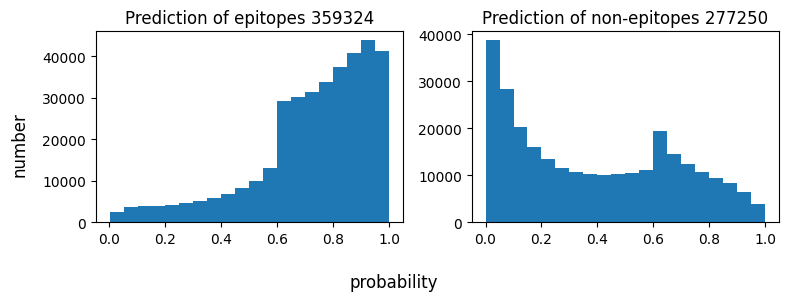

In [13]:

t = pred_test[y_test==1]
f = pred_test[y_test==0]
fig, ax = plt.subplots(1, 2, figsize=(8,3), layout='tight')
fig.supxlabel('probability')
fig.supylabel('number')

ax[0].hist(t, label='True', bins=20)
ax[0].set_title(f'Prediction of epitopes {len(t)}')
ax[1].hist(f, label='False', bins=20)
ax[1].set_title(f'Prediction of non-epitopes {len(f)}')

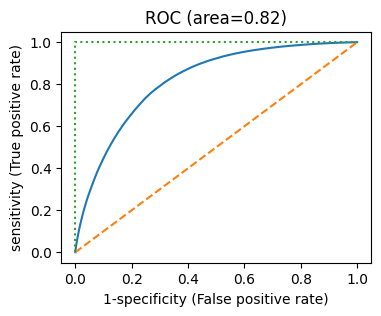

In [14]:
# ROC curve only for binary classfication
from sklearn.metrics import roc_curve, auc
# FPR, false positive rate, 1- specificity, typ I error
# TPR, true positive rate, sensitivity, power
fpr, tpr, thresholds = roc_curve(y_test, pred_test)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(1, figsize=(4,3))
ax.plot(fpr, tpr)
ax.set_xlabel('1-specificity (False positive rate)')
ax.set_ylabel('sensitivity (True positive rate)')
plt.title(f'ROC (area={roc_auc:.2f})')
ax.plot([0,1], [0,1], '--')
ax.plot([0,0,1], [0,1,1], ':')

In [15]:
# save entire model
model.save('../models/epitopes_ann_weights.keras')